# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [2]:
# Load pickled data
import math
import csv
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

%matplotlib inline

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

train_features =train['features']
train_labels = train['labels']

    
X_train, X_val, y_train, y_val = train_test_split(
    train['features'], train['labels'], test_size=0.33, random_state=0)
X_test, y_test = test['features'], test['labels']

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image? Input shape
image_shape = X_train.shape[1:]

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 26270
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


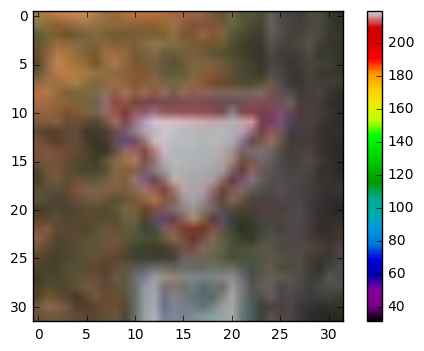

In [4]:
image = X_train[120]
print('This image is:', type(image), 'with dimesions:', image.shape)
imgplot = plt.imshow(image)
imgplot.set_cmap('spectral')
plt.colorbar()

This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


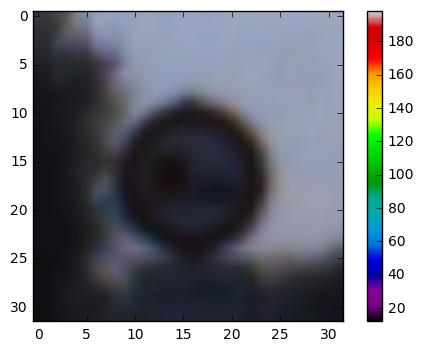

In [5]:
image = X_test[120]
print('This image is:', type(image), 'with dimesions:', image.shape)
imgplot = plt.imshow(image)
imgplot.set_cmap('spectral')
plt.colorbar()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

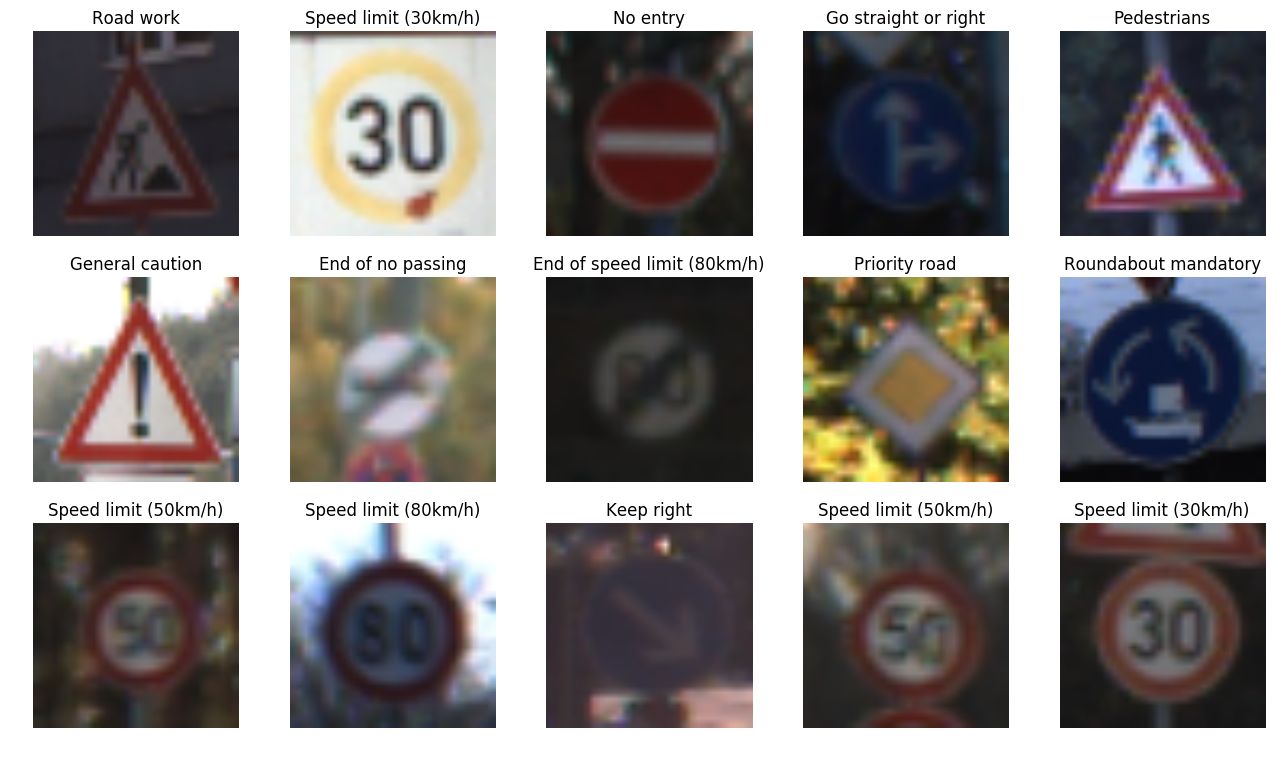

In [6]:
table = {}
with open('signnames.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile)
    for row in spamreader:
        num, sign = row
        table[num] = sign

plt.figure(figsize=[16, 9])

for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(table[str(y_train[i])])

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

batch_size = 64
n_classes = 43 # number of traffic signs
epochs = 10
input_shape = X_train.shape[1:]
print(input_shape)

# 0-255 -> 0-1
X_train /= 255
X_val /= 255
X_test /= 255

(32, 32, 3)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [8]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

features = tf.placeholder(tf.float32, (None,) + input_shape, name="features")
labels = tf.placeholder(tf.int64, (None), name="labels")

After reading the YanLeCunn paper, we can follow the way he did for preprocessing the data. The images are down-sampled to 32x32 and loaded the pickle data set which already filtered as input shape 32x32x3. As we see above the X_train, X_val and X_test are divided by 255. These idea have taken from the normalizing the features for training, validation and test data. We considered to normalize to the max for preprocessing the normalization. This brings us to the YUV Space where the Y channel is preprocessed with global and local contrast. We left U and V unchanged.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

As we noticed from the dataset exploration, the features are 32x32x3. Two options are advertised in this situation. I have decided to derive the model use convolutional network method. In addition for the training, validation and testing data, we try to keep the training and testing from the provided dataset.

Let's plan how we are going to write the functions for Deep ConvNet and pass the maxpool configuration.

The conv2d contains the convnet 2 dimensional plus the maxpool as well 2 dimensional.

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
def conv2d(input, filter, strides=(1, 1), padding='VALID'):
    kernel = tf.Variable(tf.random_normal(filter, mean=0.0, stddev=0.01))
    bias = tf.Variable(tf.zeros((filter[-1])))
    strides = (1,) + strides + (1,)
    return tf.nn.conv2d(input, kernel, strides, padding) + bias


def maxpool2d(input, ksize, strides=(1, 1), padding='VALID'):
    strides = (1,) + strides + (1,)
    ksize = (1,) + ksize + (1,)
    return tf.nn.max_pool(input, ksize, strides, padding)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Let's set our learning parameters:
We will set our learning rate to 0.001 with 10 training epoch, batch size of 64. As we know the training examples are 39209 and there are 43 classes as number of traffic signs with image shape 32x32

In this problem, our bias set in our definition conv2d. In this definition, we want to pass the input and filter with an assumption the strides would be 1,1 matrices. The kernel will be the weigths in this case. It will output random values from a normal distribution with zero mean and 0.01 standard deviation. 

I'm quoting the idea from CS231N from Stanford about Strides. ["Evaluating the original ConvNet (with FC layers) independently across 224x224 crops of the 384x384 image in strides of 32 pixels gives an identical result to forwarding the converted ConvNet one time."](http://cs231n.github.io/convolutional-networks/) 

I do care about the strides. By it means the layer I'm using filter of size 1x1 and slides it over the training image. Each time it stops (dictated by the stride-imagine it like bounding label), the filter performs a function involving the pixels that it lies on. 

Our size of image is 32x32. A 3x3 filter layer with stride 1x1 would start with the filter "overlaying" pixels (1,1),(1,3),(3,1),(3,3). I would then take the maximum of these 4 pixel values then output (1,1) of the output layer. 

As we know the stride is 1, then the filter will shift 1 pixel to the right. It will perform the same operation on (3,1),(1,3),(3,3). Once it completes the execution on the entire row, it will move one row down. Remember, our stride is 1. It will repeat the entire process again. 

In the end, we'll end up with an output layer of size 9x9, because when the filter gets to row 10, theres no eleventh row for it to function on. We can fix this with padding if we really want. We will do Fully connected two layers in this case.


In [12]:
### Train your model here.
### Feel free to use as many code cells as needed.
features = tf.placeholder(tf.float32, (None,) + input_shape, name="features")
labels = tf.placeholder(tf.int64, (None), name="labels")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# # 32 3x3 filters stride 1x1
with tf.variable_scope('conv1'):
    conv1 = conv2d(features, [3, 3, 3, 32])
    conv1 = tf.nn.relu(conv1)
    conv1 = maxpool2d(conv1, (2, 2))
# # 32 3x3 filters stride 1x1
with tf.variable_scope('conv2'):
    conv2 = conv2d(conv1, [3, 3, 32, 32])
    conv2 = tf.nn.relu(conv2)
    conv2 = maxpool2d(conv2, (2, 2))
# # 64 3x3 filters stride 1x1
with tf.variable_scope('conv3'):
    conv3 = conv2d(conv2, [3, 3, 32, 64])
    conv3 = tf.nn.relu(conv3)
    conv3 = maxpool2d(conv3, (2, 2))

# Flatten
conv3_shape = conv3.get_shape().as_list()
flattened = tf.reshape(conv3, [-1, conv3_shape[1] * conv3_shape[2] * conv3_shape[3]])
flattened_shape = flattened.get_shape().as_list()

# FC1
fc_W1 = tf.Variable(tf.random_normal((flattened_shape[-1], 512), mean=0, stddev=0.01), name="fc_W1")
fc_b1 = tf.Variable(tf.zeros((512)), name="fc_b1")

# FC2
fc_W2 = tf.Variable(tf.random_normal((512, n_classes), mean=0, stddev=0.01), name="fc_W2")
fc_b2 = tf.Variable(tf.zeros((n_classes)), name="fc_b2")

fc1 = tf.matmul(flattened, fc_W1) + fc_b1
fc1 = tf.nn.relu(fc1)
fc1 = tf.nn.dropout(fc1, keep_prob)
logits = tf.matmul(fc1, fc_W2) + fc_b2

correct_prediction = tf.equal(tf.argmax(logits, 1), labels)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

loss_op= tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels), 0)
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)


def eval_on_data(X, y, sess):
    n = 0
    total_acc = 0
    total_loss = 0
    for offset in range(0, X.shape[0], batch_size):
        end = offset + batch_size
        X_batch = X[offset:end]
        y_batch = y[offset:end]

        loss, acc = sess.run([loss_op, accuracy], feed_dict={features: X_batch, labels: y_batch, keep_prob: 1.0})
        n += 1
        total_loss += loss
        total_acc += acc

    return total_loss/n, total_acc/n

In [20]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.initialize_all_variables())
    batch_count = int(math.ceil(len(train)/batch_size))
    
    for i in range(epochs):
        for offset in range(0, X_train.shape[0], batch_size):
            end = offset + batch_size
            X_batch = X_train[offset:end]
            y_batch = y_train[offset:end]

            sess.run([loss_op, train_op], feed_dict={features: X_batch, labels: y_batch, keep_prob: 0.5})

        val_loss, val_acc = eval_on_data(X_val, y_val, sess)
        print("Epoch", i+1)
        print("Validation Loss =", val_loss)
        print("Validation Accuracy =", val_acc)
        print("")
        
    test_loss, test_acc = eval_on_data(X_test, y_test, sess)
    print("Testing Loss =", test_loss)
    print("Testing Accuracy =", test_acc)
    
    save_path = saver.save(sess, "tf_sign_recog_model.ckpt")
    print("Model saved in file: %s" % save_path)
    

Epoch 1
Validation Loss = 1.22108257081
Validation Accuracy = 0.644669447039

Epoch 2
Validation Loss = 0.185877777012
Validation Accuracy = 0.953663793103

Epoch 3
Validation Loss = 0.104664401303
Validation Accuracy = 0.973907019704

Epoch 4
Validation Loss = 0.0785947436481
Validation Accuracy = 0.978756157635

Epoch 5
Validation Loss = 0.0700007687343
Validation Accuracy = 0.981988916256

Epoch 6
Validation Loss = 0.0595976655719
Validation Accuracy = 0.985221674877

Epoch 7
Validation Loss = 0.0536259149816
Validation Accuracy = 0.98576046798

Epoch 8
Validation Loss = 0.0475574032738
Validation Accuracy = 0.987838669951

Epoch 9
Validation Loss = 0.0435813258051
Validation Accuracy = 0.989916871921

Epoch 10
Validation Loss = 0.0427601709758
Validation Accuracy = 0.990301724138

Testing Loss = 0.233678497478
Testing Accuracy = 0.952658689082
Model saved in file: tf_sign_recog_model.ckpt


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
# Restore the model
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "tf_sign_recog_model.ckpt")
  print("Model restored.")

Model restored.


/Users/Anonymous/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


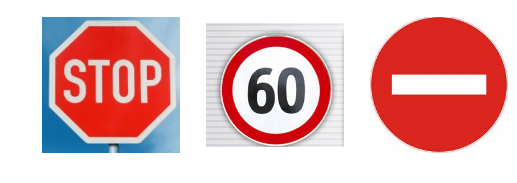

In [16]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# input image dimensions
img_rows, img_cols = 32, 32
img_channels = 3

def resize(img):
    fx = float(img_rows) / img.shape[0]
    fy = float(img_rows) / img.shape[1]
    fx = fy = min(fx, fy)
    img = cv2.resize(img, None, fx=fx, fy=fy, interpolation=cv2.INTER_NEAREST)
    outimg = np.zeros((img_rows, img_rows, img_channels), dtype=np.float32)
    w = img.shape[1]
    h = img.shape[0]
    x = (img_rows - w) / 2
    y = (img_rows - h) / 2
    outimg[y:y+h, x:x+w, :] = img
    return outimg

plt.figure()
for index, filename in enumerate(['random/test.jpg', 'random/test2.jpg', 'random/test3.jpg']):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    img /= 255
    x = resize(img)

    #Run the plotting image here
    #result = model --> new image It should recognize STOP, 60 and Don't enter
    plt.subplot(1, 3, index+1)
    plt.imshow(img)
    #plt.title(table[str(result)])
    plt.axis('off')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.